In [1]:
!pip install yfinance
!pip install torchsummaryX
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 512 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import datetime
import graphviz
import yfinance as yf
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from matplotlib import pyplot as plt

In [19]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 200)

class VolatiltiyData:

    def __init__(self, tickers, start_year, start_month, start_date, end_year,
                 end_month, end_date, freq, scaling_factor, windows, y_window):
        self.tickers = tickers
        self.start = datetime.datetime(start_year, start_month, start_date)
        self.end = datetime.datetime(end_year, end_month, end_date)
        self.freq = freq
        self.scaling_factor = scaling_factor
        # 过去几天的vol
        self.windows = windows
        # Predict几天的vol
        self.y_window = y_window 

    def get_data(self):
        """
        Output:
        raw data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 
                     'Log Adj Close', 'Log Return', 'Log Volume', 'Log Volume Chg', 'Log Range', '10-day-vol']
        """
        data = yf.download(self.tickers, start = self.start, end = self.end, interval = self.freq)
        data["Log Adj Close"] = np.log(data["Adj Close"])
        data["Log Return"] = np.insert(np.diff(data["Log Adj Close"]), 0, 0) * self.scaling_factor
        data["Log Volume"] = np.log(data["Volume"])
        data["Log Volume Chg"] = np.insert(np.diff(data["Log Volume"]), 0, 0)
        data["Log Range"] = np.log(data["High"] / data["Low"]) * self.scaling_factor
        data["10-day-vol"] = data["Log Return"].rolling(10).std(ddof=0)
        data["30-day-vol"] = data["Log Return"].rolling(30).std(ddof=0)

        return data

    def get_vix_data(self):
        """
        Output:
        raw vix data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        """
        data = yf.download("^VIX", start = self.start, end = self.end, interval = self.freq)
        
        return data

    def prepare_data(self, *args):
        """
        Prepare data for training. Select features that are needed. Perform necessary normalization.
        
        For volatiltiy data, we need to remove initial n days since we need at least n days to calculate volatiltiy.

        Input:
        Multiple types of data:
        Basic data: 10-day-vol, Log Volume Chg, Log Range
        Optional data: VIX?

        Output:
        dataset ->  (samples, features)
        scalar  ->  scalar for our normalization

        Current features:
        [10-day-vol, Log Return, Log Volume Chg, Log Range, VIX]
        """
        data = args[0]
        vol_10 = data['10-day-vol'].values.reshape(-1, 1)
        log_return = data['Log Return'].values.reshape(-1, 1)
        log_vlmchg = data['Log Volume Chg'].values.reshape(-1, 1)
        log_range = data['Log Range'].values.reshape(-1, 1)
        vol_30 = data['30-day-vol'].values.reshape(-1, 1)
        
        dataset = vol_10
        dataset = np.append(dataset, log_return, axis = 1)
        dataset = np.append(dataset, log_vlmchg, axis = 1)
        dataset = np.append(dataset, log_range, axis = 1)
        dataset = np.append(dataset, vol_30, axis = 1)
        
        # For appending more types of data -> VIX
        for i in range(1, len(args)):
            extra_data = args[i]['Adj Close'].values.reshape(-1, 1)
            dataset = np.append(dataset, extra_data, axis = 1)

        dataset = dataset[30:]
        
        # normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)

        vol_scalar = MinMaxScaler(feature_range=(0, 1)) 
        vol_scalar.fit_transform(vol_10)
        return dataset, vol_10, scaler, vol_scalar

volatiltiy_data = VolatiltiyData(
                      "^GSPC",
                      1990, 1, 2,
                      2022, 12, 12,
                      freq="1d",
                      scaling_factor=100,
                      windows=[10], # 过去几天的vol
                      y_window=10 # Predict几天的vol
                  )

data = volatiltiy_data.get_data()
# print(np.shape(data))
# print(data)
# print("#######################################################################")
vix_data = volatiltiy_data.get_vix_data()
# print(np.shape(vix_data))
# print(vix_data)
# print("#######################################################################")
dataset, vol_10, scaler, vol_scalar = volatiltiy_data.prepare_data(data, vix_data)
print(np.shape(dataset))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(8271, 6)


In [24]:
X = dataset[:-10]
y = dataset[:, 0][10:]
print(np.shape(X))
print(np.shape(y))

(8261, 6)
(8261,)


In [25]:
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size

train_X = X[:train_size]
test_X = X[train_size:]

train_y = y[:train_size]
test_y = y[train_size:]

print(np.shape(train_X))
print(np.shape(train_y))
print(np.shape(test_X))
print(np.shape(test_y))

(5782, 6)
(5782,)
(2479, 6)
(2479,)


In [10]:
n_estimators = [400, 800, 1200, 1600]
max_depths = [3, 6, 9]
etas = [0.05, 0.1, 0.2]
subsamples = [0.3, 0.6, 0.9]
colsample_bytrees = [0.3, 0.6, 0.9]

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

max_score = float('-inf')

for n_estimator in n_estimators:
  for max_depth in max_depths:
    for eta in etas:
      for subsample in subsamples:
        for colsample_bytree in colsample_bytrees:
          print("###############################################")
          print(n_estimator, max_depth, eta, subsample, colsample_bytree)
          model = XGBRegressor(n_estimators=n_estimator, max_depth=max_depth, eta=eta, subsample=subsample, colsample_bytree=colsample_bytree)
          scores = cross_val_score(model, train_X, train_y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
          print(scores.mean() * 100)
          print("###############################################")
          if scores.mean() * 100 > max_score:
            max_score = scores.mean() * 100
            best_param = (n_estimator, max_depth, eta, subsample, colsample_bytree)

print(best_param)

# define model
#model = XGBRegressor()
# define model evaluation method
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
#scores = cross_val_score(model, train_X, train_y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
#scores = abs(scores)
#print('Mean MSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

###############################################
400 3 0.05 0.3 0.3


KeyboardInterrupt: ignored

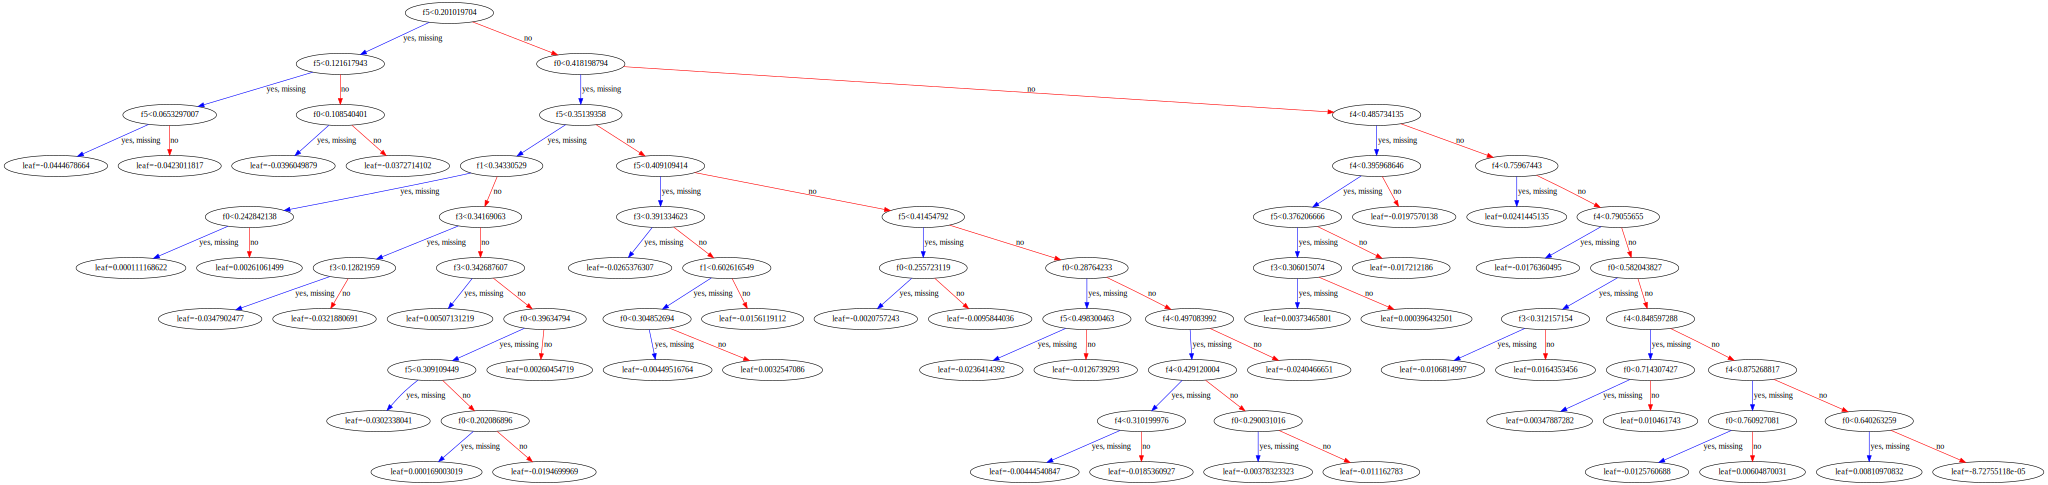

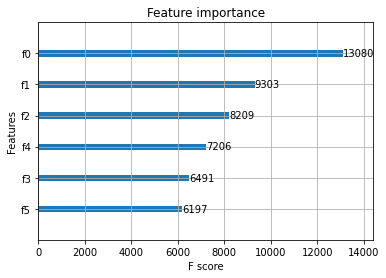

In [27]:
n_estimator, max_depth, eta, subsample, colsample_bytree = (400, 9, 0.05, 0.9, 0.9) # Trained using the code in the block above (takes long)

# define the model
XGB_model = XGBRegressor(objective='reg:squarederror', n_estimators=n_estimator, max_depth=max_depth, eta=eta, subsample=subsample, colsample_bytree=colsample_bytree)
# fit the model
XGB_model.fit(train_X, train_y)

xgb.plot_importance(XGB_model)
xgb.to_graphviz(XGB_model)

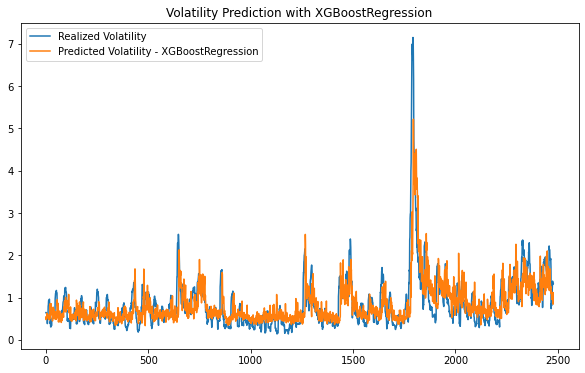

0.22808969517251326


In [17]:
pred_y = XGB_model.predict(test_X)
pred_y = vol_scalar.inverse_transform(np.array(pred_y).reshape(-1, 1))
test_y = vol_scalar.inverse_transform(np.array(test_y).reshape(-1, 1))

plt.figure(figsize=(10,6))
plt.plot(test_y, label='Realized Volatility')
plt.plot(pred_y, label='Predicted Volatility - XGBoostRegression')
plt.title('Volatility Prediction with XGBoostRegression', fontsize=12)
plt.legend()
plt.show()

mse = mean_squared_error(pred_y, test_y)
print(mse)

# New Section